<h1> Classification of Music Genres </h1>

This notebook used material from the following code sources :
[Music Genre Classification](https://colab.research.google.com/github/shaye059/ML-Music-Genre-Classification/blob/master/main/src/Machine%20Learning%20for%20Music%20Genre%20Classification.ipynb#scrollTo=HteF2ygk9igf)
[Audio Data Processing for Deep Learning in Python](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)
[Music Genre Classification using Random Forest](https://medium.com/hackerdawn/music-genre-classification-using-random-forest-219fc2446666)

<h2 id="intro"> Introduction </h2>

This project aims to classify a group of songs into their respective genres using machine learning. Identifying music genre can play a big role in recommendation systems.
<br>
The dataset for the project is the GTZAN genre collection which contains 1000 songs of 30 seconds in length equally distributed across 10 different genres. The baseline implementation will feature the raw audio signal passed into a basic neural network. The GTZAN dataset is one of the first music genre datasets and does not have names, tags, and other information that exists in others music genres Datasets (https://music-classification.github.io/tutorial/part2_basics/dataset.html). The data preprocessing will create five features :  zero-crossing rate, spectral centroid, spectral roll off, mel-frequncy cepstral coefficients and chroma frequencies.


In [1]:
## Importing all necessary libraries
import librosa
import matplotlib.pyplot as plt
import librosa.display
import sklearn
import datetime
import statistics
import random
from random import randint
from random import seed
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy import signal
from matplotlib import cm
from matplotlib.collections import PolyCollection
import numpy as np
import csv
import pandas as pd
import math

<a id="dataset"></a>
<h2 id="dataset"> The Dataset</h2>
<br><br>

The GTZAN Genre Collection was created by George Tzanetakis, a professor at the University of Victoria. This dataset contains 1000 30-second songs split into 10 genres (100 songs in each genre).<br>
The dataset contains the song in its raw form, which is the standard file format for audio files, with a sampling rate of 22050Hz. This means that a 30 second song is represented by an array containing 661 500 individual data points, where each data point is the amplitude of the signal.<br>
In the code section below, we are loading a song into the signals analysis library and simply displaying the original audio file in its raw form (figure 1), which is called a waveform.

The dataset can be obtained from Kaggle at : https://www.kaggle.com/datasets/carlthome/gtzan-genre-collection
If you are using colab, you will need to upload the data file and then unzip the file.

This song is 30 seconds long.
The sampling rate of this file is: 22050. It represents how many times per second the audio is sampled.
The value "x" represents the wave form of a song, which contains 661504 slices.
The approximate duration of the song is: 30.00018140589569. Which is what we expect since all songs are 30 seconds long.


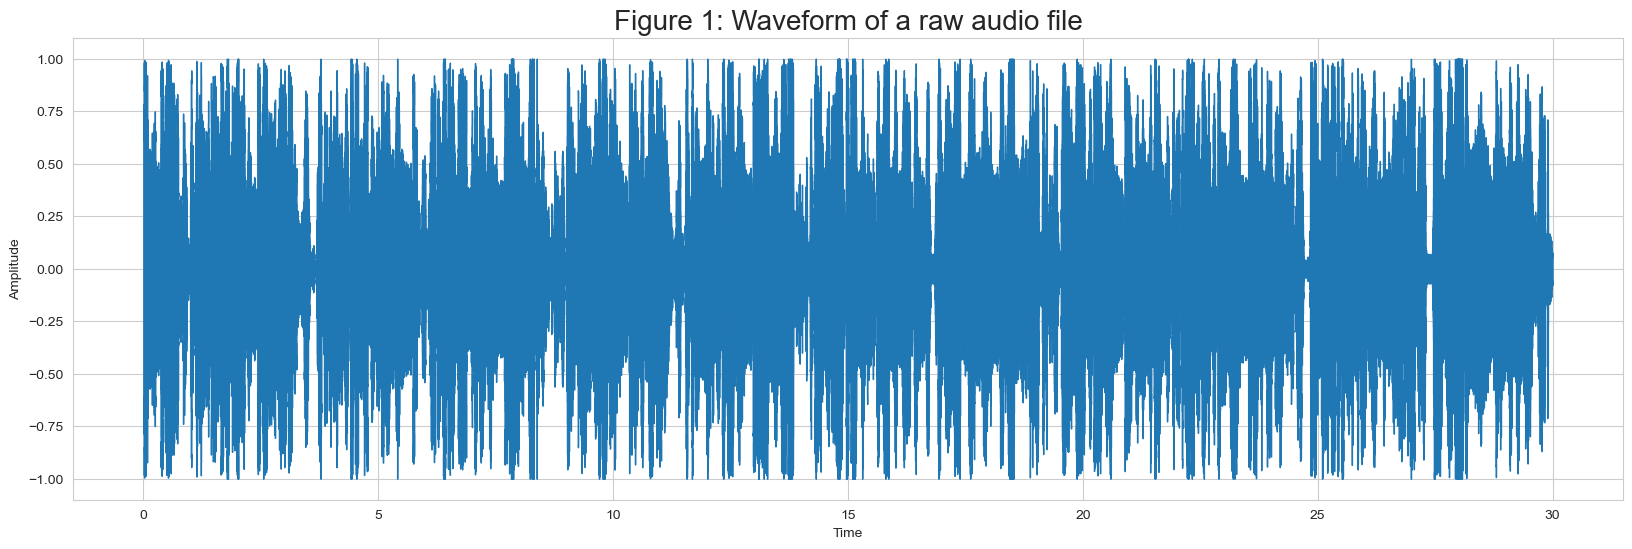

In [2]:
## Extracting the first song in the Hip Hop folder 

##### Step 1. Import the song file
print("This song is 30 seconds long.")
file_path = './genres/hiphop/hiphop.00001.au'

## Load an audio file as a floating point time series.
x , sampling_rate = librosa.load(file_path)


print("The sampling rate of this file is: {0}. It represents how many times ".format(sampling_rate) +
      "per second the audio is sampled.")
print("The value \"x\" represents the wave form of a song, which contains {0} slices.".format(x.shape[0]))
print("The approximate duration of the song is: {0}. Which is what we expect since all songs are 30 seconds long.".format(len(x)/sampling_rate))

## Plot the waveform of the loaded file
plt.figure(figsize=(20, 6))
plt.title("Figure 1: Waveform of a raw audio file",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
librosa.display.waveshow(x, sr=sampling_rate)




<h2 id="features_extract"> Feature Extraction (Dataset Preprocessing) </h2>

Recall that the dataset contains songs in their raw form. This representation of music does not provide enough information to be able to correctly and consistently classify the song's genre. Therefore, the data requires preprocessing before it can be used in the later stages of the project. <br>

This preprocessing takes the form of music feature extraction, which is signal processing with the intent of extracting unique identifying attributes from the song such that it can be passed to machine learning algorithms. The following five features were selected to be extracted: zero crossing rate, spectral centroid, spectral roll off, mel-frequency cepstral coefficients (MFCC), and chroma frequencies. The characteristics will be further explained as well as illustrated graphically in following sections of the report. <br>

Throughout this portion of the project the python library librosa was used since it contains all relevant music-oriented signals processing methods that were required.


<h4 id="spectrogram"> Spectrogram </h4>

Given that all the songs in the dataset are in their raw form, they must first be transformed into an alternate form which is more apt for feature extraction. This new form is the spectrogram which is simply a decomposition of all the component frequencies (over time) which combine to create the raw audio signal. <br>

The conversion of the raw song to the spectrogram was acheived by using the Short-Time Fourier Transrom(STFT). Specifically by running the librosa.stft() function.
  
The STFT breaks down a signal into amplitude over time of each frequency. To demonstrate this more clearly, figure 2 below shows a 3D spectrogram example from Wikipedia. Now, let's take an example of a sound recording. The frequency axis represents all the possible frequencies in that recording. The time axis represents different times in the recording. The z or amplitude axis represents the amplitude (or level) of sound.

In the figure, the amplitude of the low frequencies is also low. As the frequency gets higher, the amplitude also increases, meaning this recording was of a higher pitched sound.

The plots in the next section represent the same thing as figure 1 and have the same frequency and time axis. However, instead of a third dimension for amplitude, they uses colour to show higher amplitudes across the 2D plane. 
<br>



<h4> Transformation of the waveform into a spectrogram. </h4>

Fourier Transform is a function that takes a signal in the time domain as input and outputs its decomposition into frequencies. Let’s plot a graph using it to see the distribution of frequencies.

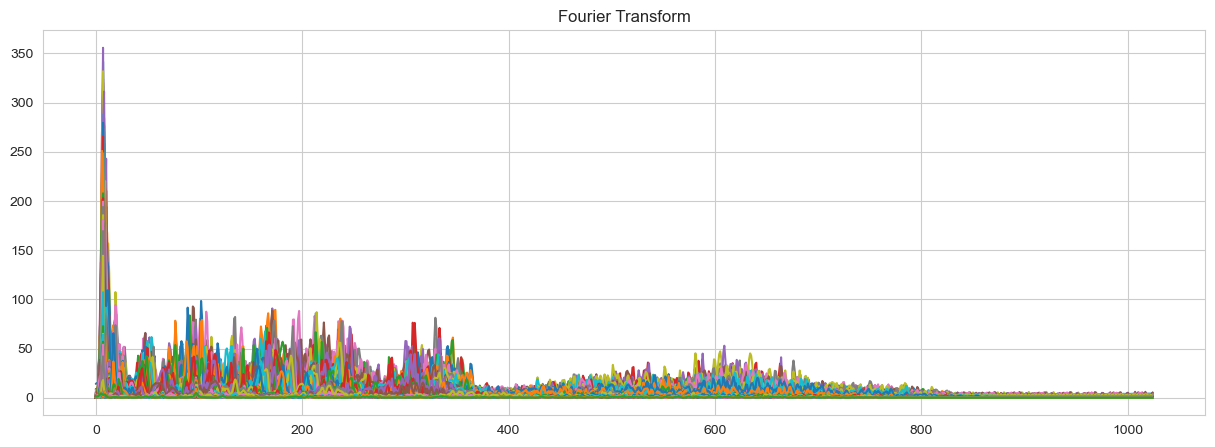

In [3]:
n_fft = 2048
hop_length = 512
D = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length))
plt.figure(figsize = (15, 5))
plt.plot(D)
plt.title('Fourier Transform')
plt.show()

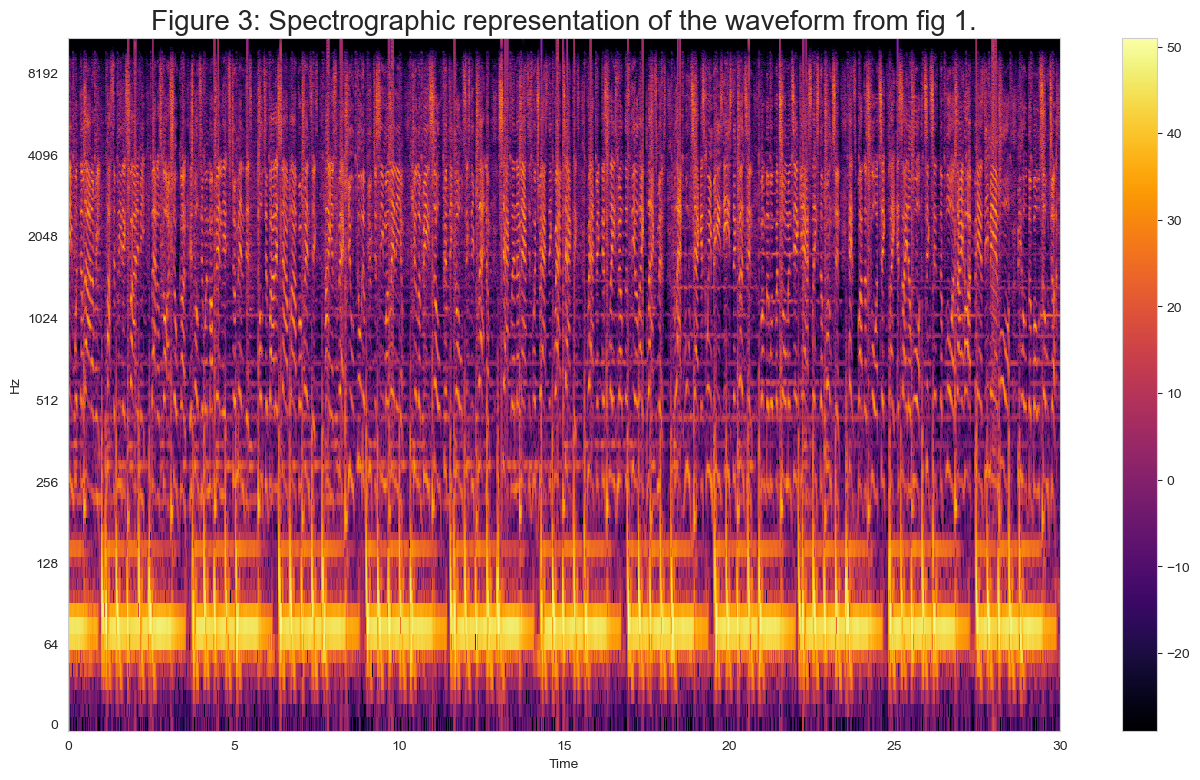

In [4]:
##### Apply Short-Time Fourier Transform (STFT) to Decompose Wave Form to base frequencies

## This function converts our file into a time-frequency domain representation using short-time Fourier transform 
## (essentially this is the change of FFT's over time)
wav_form = librosa.stft(x)
S_spectogram, phase_spectogram = librosa.magphase(librosa.stft(y=x))

## Plot the spectrogram of the STFT representation
wav_form_db = librosa.amplitude_to_db(abs(wav_form))
plt.figure(figsize=(16,9))
plt.title("Figure 3: Spectrographic representation of the waveform from fig 1.",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Frequency(Hz)")
librosa.display.specshow(wav_form_db, sr=sampling_rate, x_axis='time', y_axis='log')
plt.colorbar()
plt.inferno()


When considering figure 3, it is as if one is looking at figure 2 in a top down view, where the color gradient represents the amplitude for any given time and frequency.


<h4 id="ZCR"> Zero Crossing Rate </h4>

The first feature to be extracted is the zero-crossing rate (ZCR). The ZCR actually comes from the waveform, and it represents the number of times the signal cross the 0-amplitude (x-axis). ZCR is a good indication for the noisiness of a signal and it can be useful to distinguish a genre like rock, which is typically much noisier, from another genre like jazz<sup>1</sup>.

In the code section bellow, the ZCR is calculated for a miniscule portion of the song. The example bellow (figure 6) represents 4.5 millisecond frame or 100 slices (recall that a song is sampled 22050 times in a second, so a slice is a single sample).

The song snippet in figure 6 has a ZCR of 15, whereas the entire song has a ZCR of 97628.



From the image below which represents a small slice of time. The number of crossings 0 is 13 



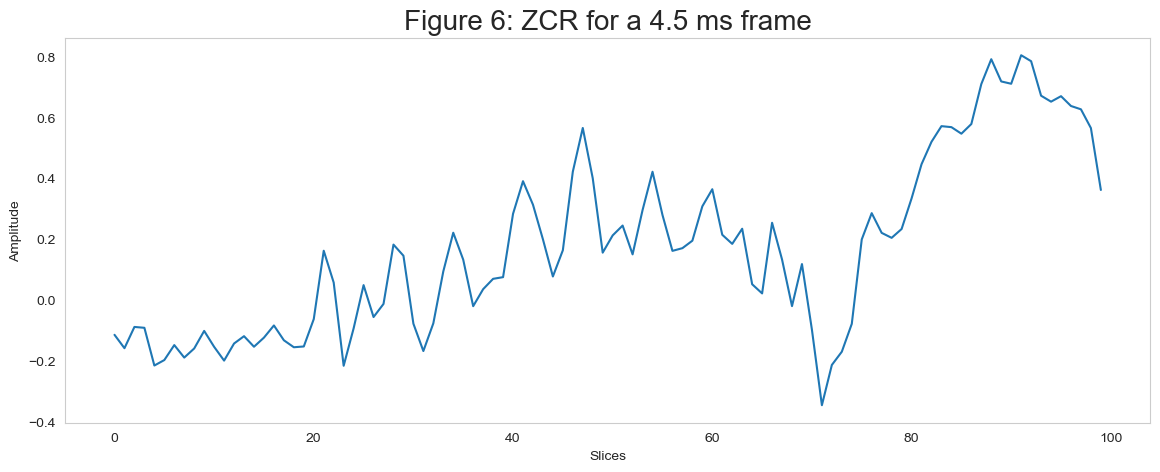

In [5]:
#Feature 1: Zero-Crossing Rate
## This represents how many times the frequency passes the "0" x-axis in either negative or positive direction.
m0 = 10000
m1 = 10100
plt.figure(figsize=(14,5))
plt.title("Figure 6: ZCR for a 4.5 ms frame",fontdict={'fontsize':20})
plt.xlabel("Slices")
plt.ylabel("Amplitude")
plt.plot(x[m0:m1])
plt.grid()
zero_crossing_sample = librosa.zero_crossings(x[m0:m1], pad=False)
print("From the image below which represents a small slice of time. The number of crossings " +
     "0 is {0} \n".format(sum(zero_crossing_sample)))

In [6]:
# Zero Crossing feature applied to entire song
zero_crossings = librosa.zero_crossings(y=x, pad=False)
print("When this idea of zero crossings is extended to the entire 30 second portion of a song, this song has " + 
      "{0} zero crossings".format(sum(zero_crossings)))

When this idea of zero crossings is extended to the entire 30 second portion of a song, this song has 64771 zero crossings


<h4 id="spect_cent"> Spectral Centroid </h4>

The second feature, the spectral centroid, calculates the average 'power' of all the frequencies for that given point in time which the slice represents. When the spectral is calculated for the entire song the result is a smooth curve over the entire spectrogram or waveform. Generally speaking, different genres will have different spectral centroid values. A more rhythmic and song will have a spectral centroid near the centre while something like classical or metal, or any song that builds to a crescendo will have a spectral centroid closer to the end<sup>1</sup>.

In the code section bellow, the spectral centroid is calculated over 100 000 slices or a song snippet of ~4.5 seconds long. The resultant curve is plotted over its corresponding waveform (figure 7) and spectrogram (figure 8).

Of note, librosa.feature.spectral_centroid() returns an array of values in Hz, therefore to plot over a waveform the values were normalized.  
  


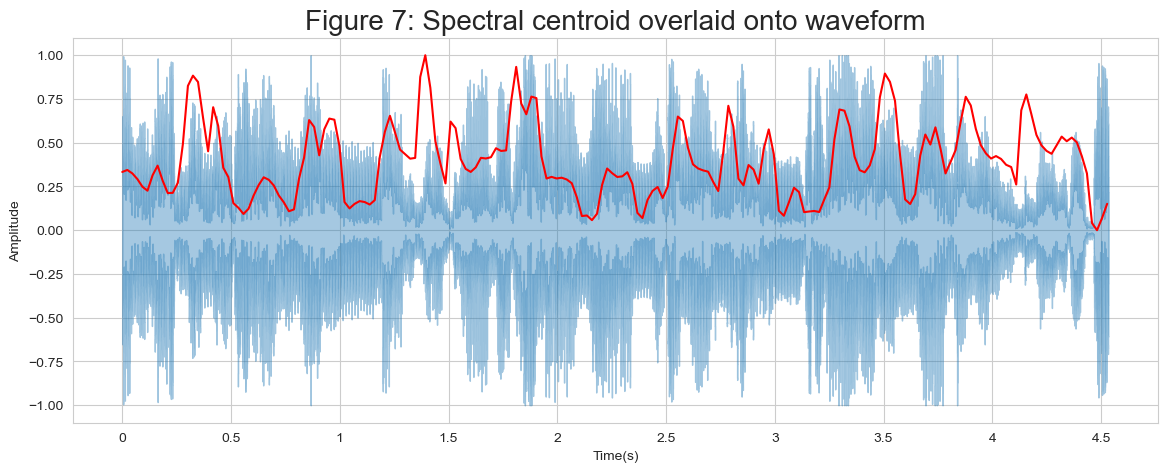

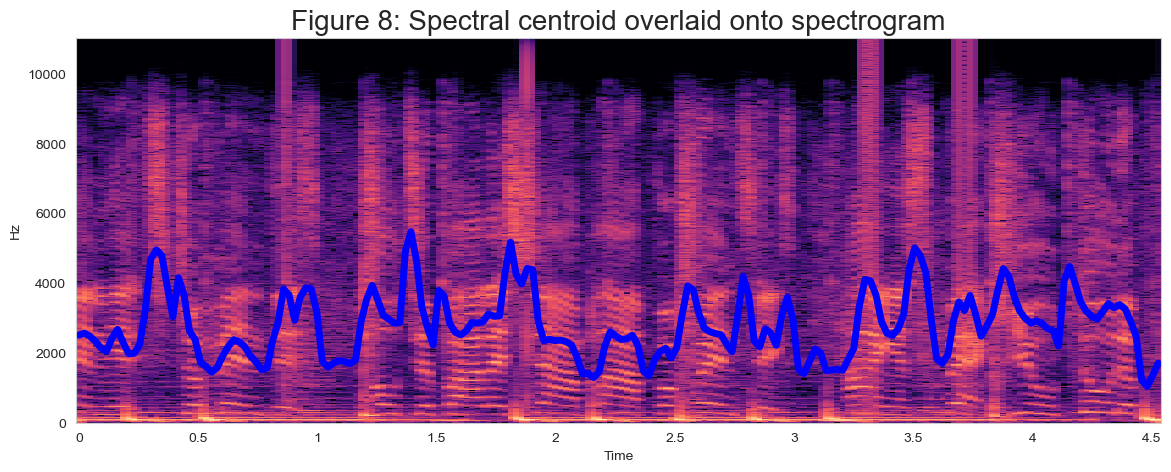

In [7]:
# Feature 2: Spectral Centroid 
## This feature represents taking a "slice" of a song and then taking the average of all frequencies at the
## point in time the slice represents. Extend this idea to ALL slices that make up a song, and
## using these averages plot a line that traverses exactly through each point, this is the Spectral Centroid
## of a song. This is important because two different genres may "generally" have a different spectral centroid line.

# Smaller Sample taken for demonstration below
n0 = 100000
n1 = 200000
x_sample = x[n0:n1]

spectral_centroids_sample = librosa.feature.spectral_centroid(y=x_sample, sr=sampling_rate)[0]
spectral_centroids_sample.shape

frames = range(len(spectral_centroids_sample))
t = librosa.frames_to_time(frames)

# Normalize
def normalize(x_sample, axis=0):
    return sklearn.preprocessing.minmax_scale(x_sample, axis=axis)
plt.figure(figsize=(14,5))
librosa.display.waveshow(x_sample, sr=sampling_rate, alpha=0.4)
plt.title("Figure 7: Spectral centroid overlaid onto waveform",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.plot(t, normalize(spectral_centroids_sample), color='r')


S_sample, phase_sample = librosa.magphase(librosa.stft(y=x_sample))
plt.figure(figsize = (14,5))
plt.title("Figure 8: Spectral centroid overlaid onto spectrogram",fontdict={'fontsize':20})
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
librosa.display.specshow(librosa.amplitude_to_db(S_sample, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_centroids_sample, lw = 5.0, color='b')

In [8]:
# Full song taken as spectral_centroid

spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sampling_rate)[0]

<a id="spect_ro"></a>
<h4 id="spect_ro"> Spectral Rolloff </h4>

The third feature, spectral roll off is similar to the spectral centroid. However instead of calculating the average power of a slice, it takes the sum of all the power for the frequencies in the slices and then it calculates when/where it reaches 85% (for example) of that sum on the spectrum. The %-value can vary, however the standard value is 85%.

As an example, let’s say a given slice has frequency distribution of 0-100Hz and each Hz has 1% of the sum total of the power for that slice. Therefore, when calculating the spectral roll off at 85% for this slice the result will be 85Hz.
  
In the code section bellow, the spectral roll off is calculated over the entire 30 second song at various roll off percentages and then displayed over waveform and spectrogram (logarithmic and linear scale).

Similar to spectral centroid, librosa.feature.spectral_rolloff() also returns an array of values in Hz, therefore to plot over a waveform the values were again normalized.
  
  


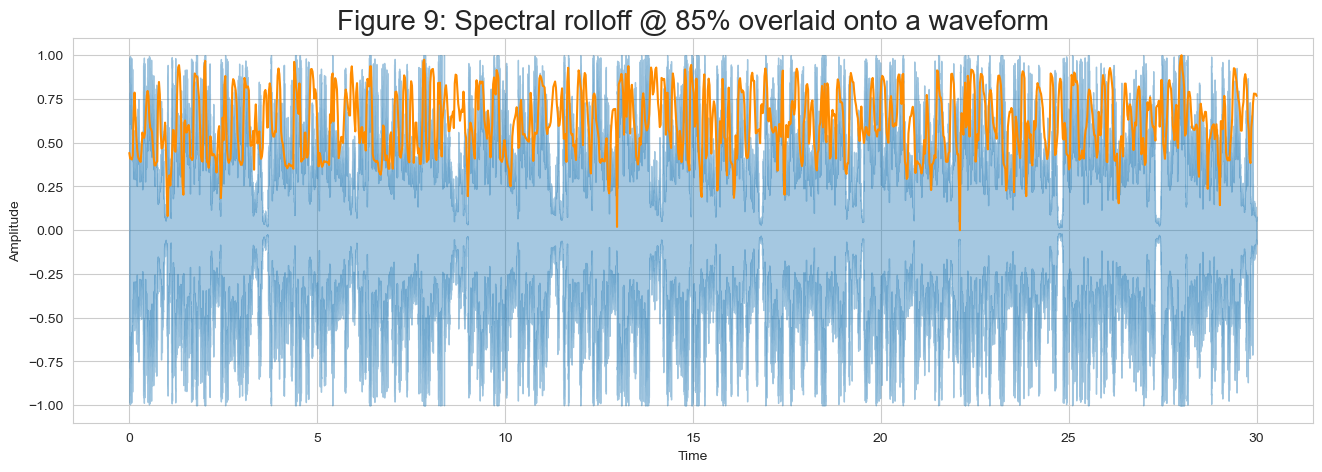

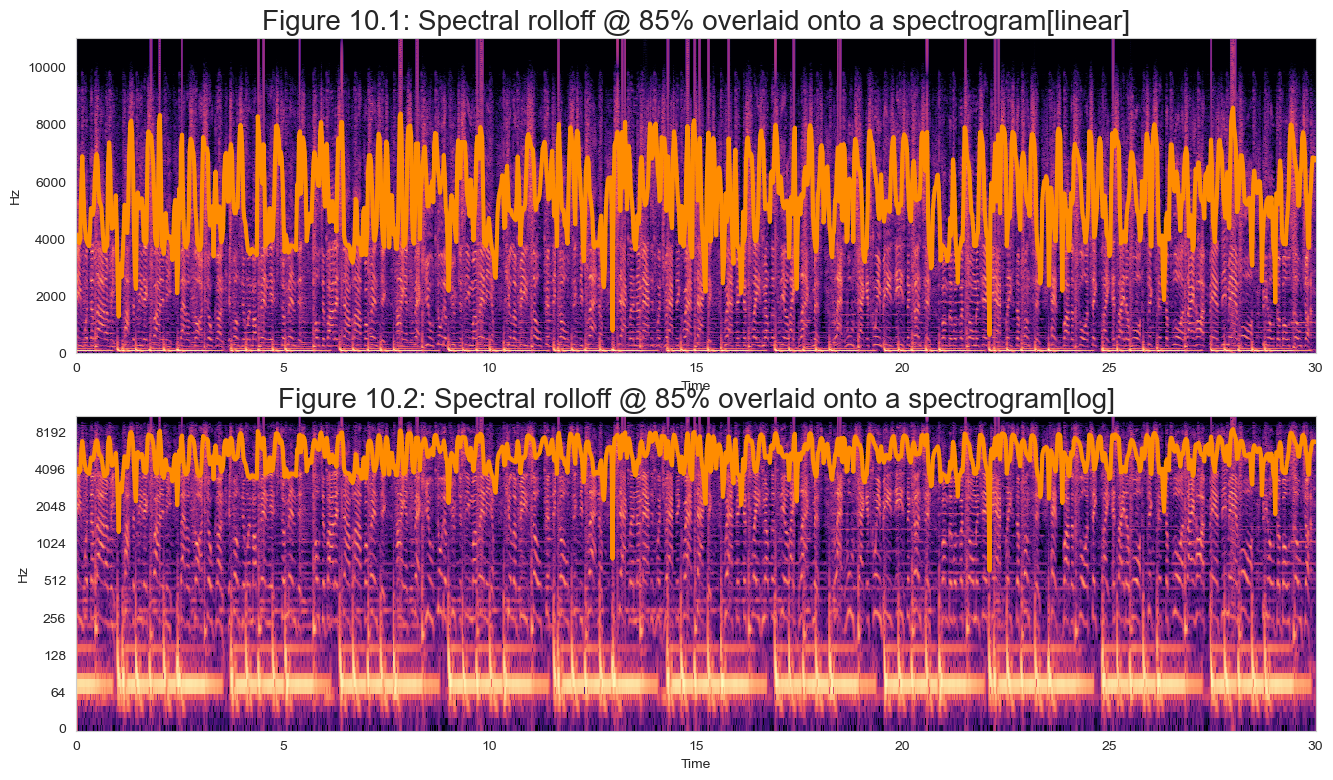

In [13]:
# Feature 3: Spectral Roll-off
## For a single slice of the stft the total "Energy" of all frequencies it is composed of is always equal
## to "100%". Spectral-Roll off finds the frequency at which a certain given percentage of the energy is. For
## example, the Spectral Roll-Off at 85% of a song might be at 6000Hz. To find this value, it adds these composite
## frequencies in order of lowest frequencies in terms of Hz, to higher frequencies. This approach is applied to the
## entire song at each slice which ends up creating a series of points on a graph that are joined together by a line
## passing directly through all points to create the Spectral Roll-off.

## Spectral Roll Percent at 85% 

spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sampling_rate, roll_percent=0.85)[0]

frames = range(len(spectral_rolloff))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(16,5))
plt.title("Figure 9: Spectral rolloff @ 85% overlaid onto a waveform",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
librosa.display.waveshow(x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff), color='darkorange')


plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
plt.title("Figure 10.1: Spectral rolloff @ 85% overlaid onto a spectrogram[linear]",fontdict={'fontsize':20})
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_rolloff, color='darkorange', lw=3)
plt.subplot(2,1,2)
plt.title("Figure 10.2: Spectral rolloff @ 85% overlaid onto a spectrogram[log]",fontdict={'fontsize':20})
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='log', x_axis='time')
plt.plot(t,spectral_rolloff, color='darkorange', lw=3)
plt.show()

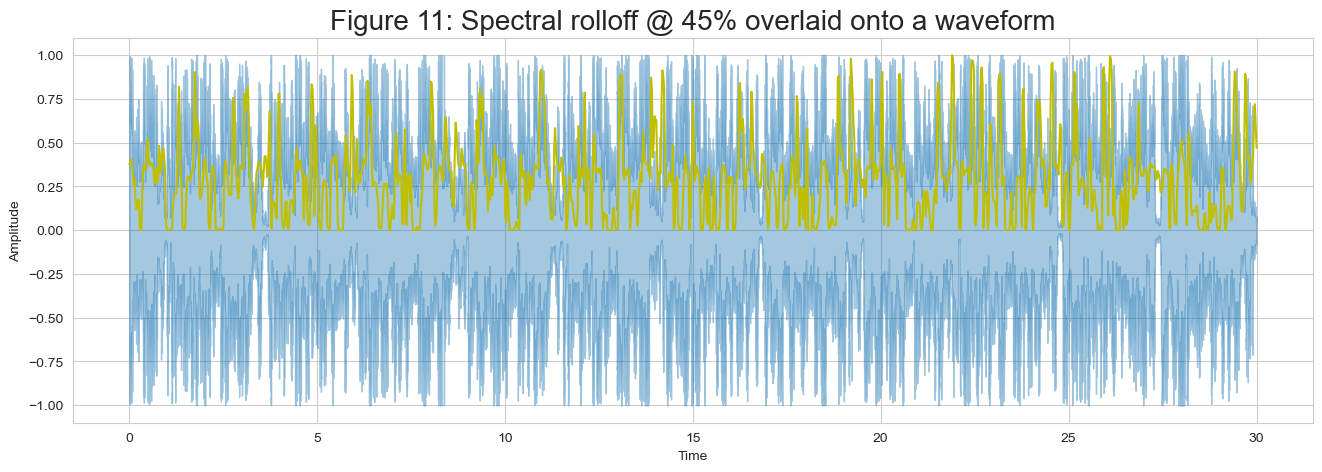

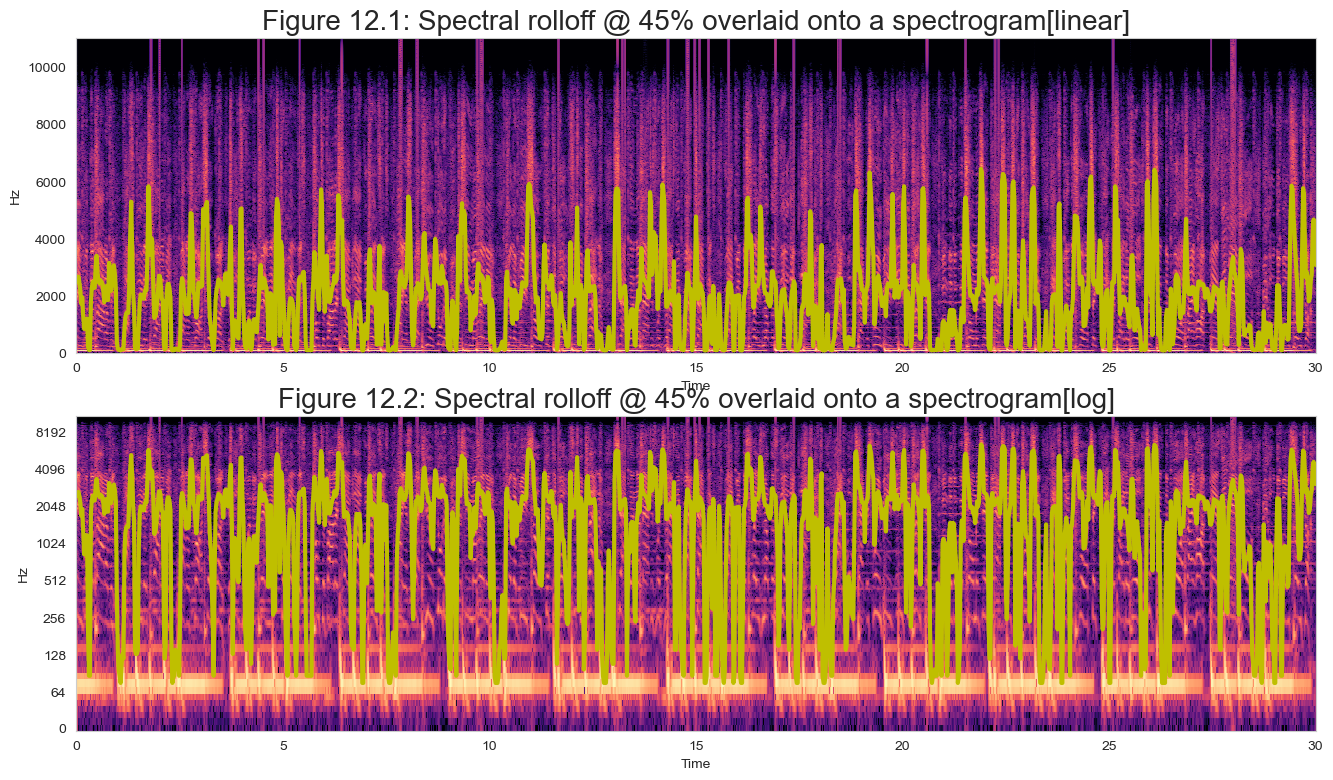

In [12]:
## Spectral Roll Percent at 45%
spectral_rolloff_2= librosa.feature.spectral_rolloff(y=x+0.01, sr=sampling_rate, roll_percent=0.45)[0]
plt.figure(figsize=(16,5))
plt.title("Figure 11: Spectral rolloff @ 45% overlaid onto a waveform",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
librosa.display.waveshow(x, sr=sampling_rate, alpha=0.4)
plt.plot(t, normalize(spectral_rolloff_2), color='y')

plt.figure(figsize = (16,9))
plt.subplot(2,1,1)
plt.title("Figure 12.1: Spectral rolloff @ 45% overlaid onto a spectrogram[linear]",fontdict={'fontsize':20})
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='hz', x_axis='time')
plt.plot(t,spectral_rolloff_2, color='y', lw=3)
plt.subplot(2,1,2)
plt.title("Figure 12.2: Spectral rolloff @ 45% overlaid onto a spectrogram[log]",fontdict={'fontsize':20})
librosa.display.specshow(librosa.amplitude_to_db(S_spectogram, ref=np.max),y_axis='log', x_axis='time')
plt.plot(t,spectral_rolloff_2, color='y', lw=3)
plt.show()

<a id="MFCC"></a>
<h4 id="MFCC"> MFCC </h4>

The fourth feature, mel-frequency cepstral coefficients (MFCC) is used to identify the lingustic component of an audio signal and models the human voice. Certain genres are almost always instrumental, like classical, while other typically have lyrics which accompany the music. MFCC can help differentiate songs with vs. without a human voice<sup>1</sup>.

The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. Humans are much better at discerning small changes in pitch at low frequencies than they are at high frequencies. Incorporating this scale makes our features match more closely what humans hear.

An audio signal will be distributed into 20 distinct bins, each representing a seperate MFCC coefficents, where the value of the bin represents the power mel-spectrum. That is to say there is 20 distinct data points for each slice.

In the code section bellow, the MFCC is calculated over the entire 30 second song and displayed in figure 16. In the figure the 20 bins are distinctly visible as horizontal bans.
  


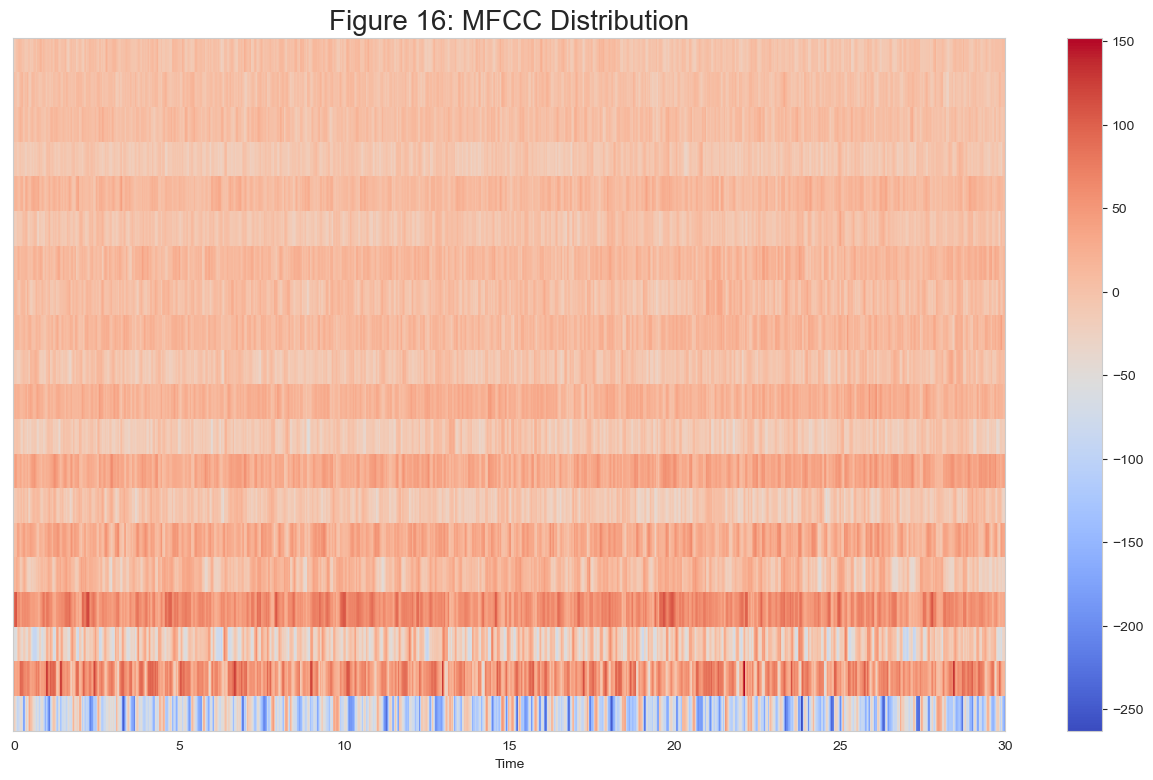

In [14]:
# Feature 4: Mel-Frequency Cepstral Coefficients (MFCC)
## This feature represents:This feature is a way to represent human auditory sounds

mfccs = librosa.feature.mfcc(y=x, sr=sampling_rate)

plt.figure(figsize=(16,9))
plt.title("Figure 16: MFCC Distribution",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Bins")
librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')
plt.colorbar()

<a id="chroma"></a>
<h4 id="chroma"> Chroma Frequencies </h4>

The last feature is the chroma frequencies where the audio signal is projected into 12 bins representing the 12 disctinct semitiones of a musical octave (C, C#, D, D#, E, F, F#, G, G#, A, A#, B). The value associated with each bin represnets the relative power for the semitone for the given slice; and each slice will be represented by 12 values<sup>1</sup>. 

Although it is possible to increase the number of bins to encompas multiple octaves, this is uncessary since notes which are exactly an octave apart are perceived very similarly regardless of the base frequency.


In the code section below, the chroma frenquencies are calculated over the entire 30 second song and displayed in figure 17.
  
   

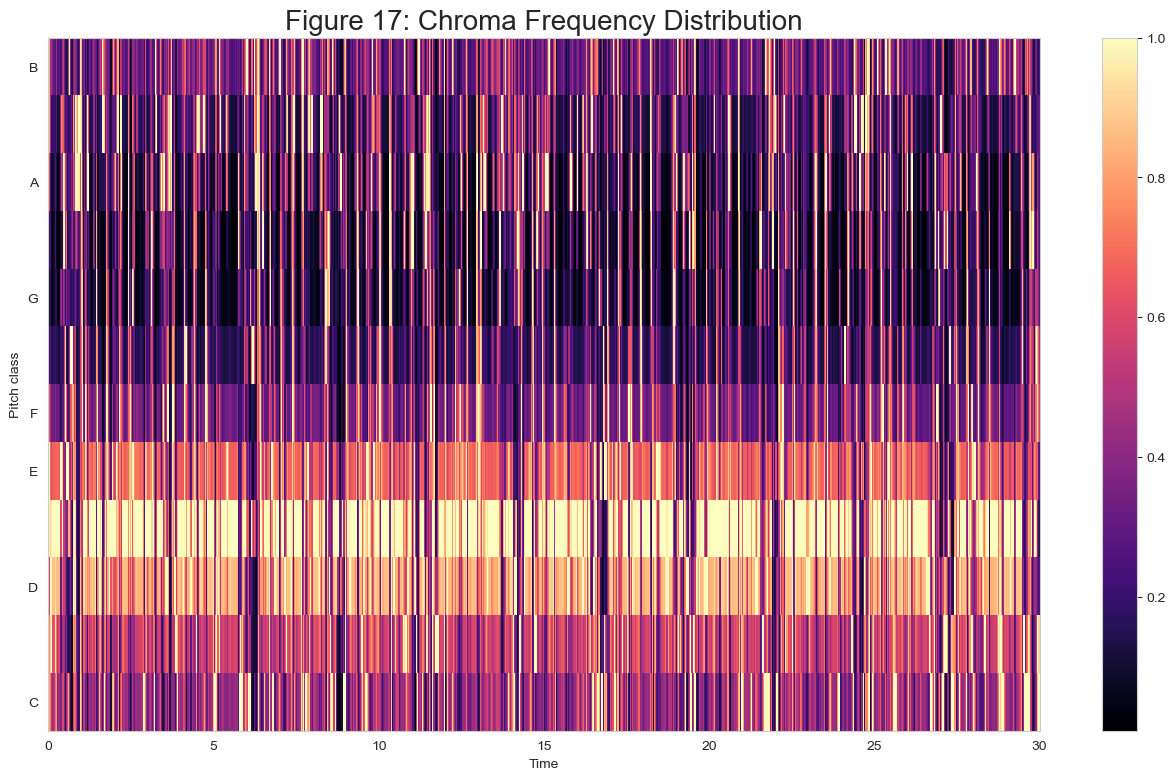

In [15]:
# Feature 5: Chroma Frequencies
## This feature represents: This will will divide the spectrum in to 12 distinct semitones that represent that
## represent a musical octave, for the entire song.

chromagram = librosa.feature.chroma_stft(y=x, sr=sampling_rate )
plt.figure(figsize=(16,9))
plt.title("Figure 17: Chroma Frequency Distribution",fontdict={'fontsize':20})
plt.xlabel("Time(s)")
plt.ylabel("Semitones")
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma')
plt.colorbar()
plt.magma()

<h2 id="csv"> CSV Creation and Data Formatting</h2>

<h4 id="csv_feat"> Five Feature Data Extraction and Formatting</h4>

The following section of code defines all the functions required to generate the CSV files, extract the feature data from the spectrogram, and store it in the CSV. The data values for the five features are being calculated every 2 msec (or every 512 slices). Calculating the values at 512 slice intervals is perfectly acceptable while avoiding an overly large amount of data (861 data points instead of 441 000 data points to represent a 20 second song snippet). Additionally, each of the 20 MFCC bins and the 12 chroma frequencies are treated as a separate data point. Therefore the 5 features become 35 distinct data types.

In order to make the CSV data tables more manageable and have consistent size CSV files regardless of the length of the song the intermediary results were compressed into a singular datapoint for each data type. This was achieved by taking the mean of all
data points resulting in a simple array of length of 35 to represent one song.

Lastly, it is possible to specify a specific roll off percentage for the spectral roll off; nevertheless, the normal 85% value was used for the project.


In [16]:
## Create a csv file into which the 5 features will be written. The file will include a column for the filename,
## genre, and clomuns for all the features. 

def csvCreatorFiveFeat (file_name):
    header_elements =["filename ", "spectral_centroid ",  "rolloff ", "zero_crossing_rate"]
    pitch = ["c", "c#", "d", "d#","e", "f", "f#", "g", "g#", "a", "a#", "b"]
    header=''
    for l in range (1, 21):
        header_elements.append(f' mfcc{l}')
    for i in range (1,13):
        header_elements.append(f"chroma_pitch_{pitch[i-1]}") 
    header_elements.append('genre')
    file = open(file_name,'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header_elements)

## CSV Appendor Method for adding the extracted music feautres to the CSV File. It takes as input each of the features
## as well as the name of the CSV file they will be added to, and then appends each.
def csvAppendor (csvFile, zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, song_file_path, genre):
    to_append =f'{song_file_path} {np.mean(spectral_centroids)} {np.mean(spectral_rolloff)} {sum(zcr)}'   
    for e in mfccs:
        to_append += f' {np.mean(e)}'
    for h in chroma:
        to_append += f' {np.mean(h)}'
    to_append += " "
    to_append += genre
    file = open(csvFile, 'a', newline='')  
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())

## Feature Extraction Method. The location of the song file is determined by songFilePath and the sample is taken
## from startPoint and has a length determined by duration. rollPercent represents the percentage at which we want
## to calculate the spectral rolloff, as explained earlier in this notebook.

def featureExtractor (songFilePath, startTime, duration,rollPercent):
    x , sampling_rate = librosa.load(songFilePath, offset= startTime, duration=duration)
    zcr = librosa.zero_crossings(y=x)
    spectral_centroids = librosa.feature.spectral_centroid(y=x, sr=sampling_rate)[0]
    spectral_rolloff = librosa.feature.spectral_rolloff(y=x+0.01, sr=sampling_rate, roll_percent=rollPercent)[0]
    mfccs = librosa.feature.mfcc(y=x, sr=sampling_rate)
    chroma = librosa.feature.chroma_stft(y=x, sr=sampling_rate)
    
    return zcr, spectral_centroids, spectral_rolloff, mfccs, chroma

<h4> Create new feature CSV file : ONLY RUN if you have new columns or data to add </h4>

The following section of code applies the previous methods to all 1000 songs at the 5, 10 and 20 secconds durations. A counter showing the genre is included to show the progress of the extraction.

In [84]:
## Call the csvCreatorFiveFeat function to create the CSV files for 20 and 30 second samples

csvCreatorFiveFeat('feature_extraction_20sec.csv')
csvCreatorFiveFeat('feature_extraction_30sec.csv')

## Create a list of the 10 genres in the dataset to iterate through
genres = ["blues","classical","country","disco","hiphop","jazz","metal","pop","reggae","rock"]

file_path_b='./genres/'

## Iterate through the list of genres and for each one, open the folder containing its songs and for every song,
## create a 5, 10, and 20 second sample and write those samples into their respective CSV file.
print("Start")
for x in genres:
    file_path_g= file_path_b + x +'/'+x +'.000'
    for y in range(0, 100):
        y_string = str(y)
        file_path_s = file_path_g + y_string.rjust(2,'0') + '.au'
        
         #extracting features from 20 seconds
        zcr, spectral_centroids, spectral_rolloff, mfccs, chroma = featureExtractor(file_path_s, 10,20,0.85)
        csvAppendor('feature_extraction_20sec.csv',zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, file_path_s[file_path_s.rfind('/')+1:], x)
         #extracting features from 30 seconds
        zcr, spectral_centroids, spectral_rolloff, mfccs, chroma = featureExtractor(file_path_s, 0,30,0.85)
        csvAppendor('feature_extraction_30sec.csv',zcr, spectral_centroids, spectral_rolloff, mfccs, chroma, file_path_s[file_path_s.rfind('/')+1:], x)
    print(x)
print("End")


Start
blues
classical
country
disco
hiphop
jazz
metal
pop
reggae
rock
End


<h4 > Sample Five Feature Data</h4>

Below is a subset of the data which will be used in the improved models.

In [85]:
# Read the data from the features CSV into a pandas DataFrame and then display the first 110 rows
X = pd.read_csv("./feature_extraction_30sec.csv")
X.head(110)

filename   spectral_centroid      rolloff   zero_crossing_rate  \
0        blues.00000.au         1784.416546  3776.702163               55013   
1        blues.00001.au         1529.871314  3448.929145               37123   
2        blues.00002.au         1552.637786  3013.848442               50538   
3        blues.00003.au         1070.110059  2124.678819               22062   
4        blues.00004.au         1835.507009  3525.870346               67210   
..                  ...                 ...          ...                 ...   
105  classical.00005.au         1431.542307  2695.867032               49825   
106  classical.00006.au         1372.821499  2598.275955               48297   
107  classical.00007.au         1358.926260  2516.834781               48446   
108  classical.00008.au         1516.648040  2823.616259               52179   
109  classical.00009.au         1216.426225  2269.569610               37264   

          mfcc1       mfcc2      mfcc3      mfcc4      mfcc5      mfcc6  ...  \
0   -113.619385  121.553017 -19.151056  42.345768  -6.371168  18.613033  ...   
1   -207.581512  123.997147   8.939115  35.870758   2.919970  21.518787  ...   
2    -90.776344  140.448608 -29.100559  31.687340 -13.975973  25.741686  ...   
3   -199.462006  150.094727   5.649167  26.870144   1.755441  14.236880  ...   
4   -160.291855  126.195763 -35.602501  22.151169 -32.487640  10.862022  ...   
..          ...         ...        ...        ...        ...        ...  ...   
105 -264.277405  138.150925 -30.101551  37.824230  -7.180179   6.782936  ...   
106 -295.743530  134.538330 -22.449306  40.759247  -5.875980   9.276347  ...   
107 -286.868225  135.918350 -24.436617  36.661171  -6.245214   6.962934  ...   
108 -292.152924  127.763664 -29.909023  37.442085  -9.556902   5.113049  ...   
109 -356.143951  139.792862  -6.286765  43.188293  -8.879337  11.050314  ...   

     chroma_pitch_d#  chroma_pitch_e  chroma_pitch_f  chroma_pitch_f#  \
0           0.244635        0.247802        0.335615         0.364576   
1           0.211586        0.200908        0.331005         0.397647   
2           0.408135        0.547083        0.321775         0.304787   
3           0.547075        0.657113        0.511671         0.355631   
4           0.255906        0.192804        0.530582         0.253942   
..               ...             ...             ...              ...   
105         0.388960        0.184424        0.276382         0.164692   
106         0.234142        0.173851        0.276595         0.190859   
107         0.395320        0.204883        0.390249         0.174690   
108         0.168781        0.173462        0.325897         0.174796   
109         0.416479        0.181393        0.179323         0.232003   

     chroma_pitch_g  chroma_pitch_g#  chroma_pitch_a  chroma_pitch_a#  \
0          0.435647         0.295841        0.314634         0.406560   
1          0.560677         0.384379        0.255474         0.284959   
2          0.288517         0.334242        0.401911         0.384308   
3          0.251690         0.246386        0.315209         0.316543   
4          0.139215         0.276555        0.324336         0.555298   
..              ...              ...             ...              ...   
105        0.362295         0.429849        0.254002         0.258523   
106        0.297423         0.315989        0.156565         0.188606   
107        0.275999         0.306214        0.258416         0.468887   
108        0.246950         0.194027        0.313628         0.342269   
109        0.321835         0.213129        0.254416         0.281668   

     chroma_pitch_b      genre  
0          0.384770      blues  
1          0.334238      blues  
2          0.588190      blues  
3          0.382855      blues  
4          0.273030      blues  
..              ...        ...  
105        0.176905  classical  
106        0.297647  classical  
107        0.172120  classical  
108     

<h4> Read the csv file and populate y and X variables for analysis </h4>
<br>

The following code is simply methods required for the preprocessing of the CSV file for the analysis routines.

In [86]:
def read_data(file_name):
    data = pd.read_csv(file_name)
    #print("*BEFORE* Shape of data file \"{0}\" is: {1}".format(file_name, data.shape))
    return data

def create_genre_list(data):
    genre_list = data.iloc[:, -1]
    return genre_list

# Encoding occurs in here
def get_y_value(data):
    genre_list = create_genre_list(data)
    encoder = preprocessing.LabelEncoder()
    y = encoder.fit_transform(genre_list)
    return y

# Scaling occurs in here
def get_x_value(data):
    data = data.drop(['filename '],axis=1)
    data = data.drop(['genre'],axis=1)
    scaler = preprocessing.StandardScaler()
    X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
    #print("*AFTER* Shape of data file is: {0}".format(data.shape))
    return X


In [101]:
data = read_data("./feature_extraction_30sec.csv")
y = get_y_value(data)
X = get_x_value(data)
print(y.shape,X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

(1000,) (1000, 34)


<h2> Analysis of data using the Random forest routine </h2>

In [102]:
model = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, preds))

Accuracy: 0.66


<h2 >Conclusion</h2>

This notebook on the classification of music in to genres solved the problem with the following steps. Audio filesin genre subdirectories were read in, a number of audio feature routines were calculated, and then the results was written the result to a csv file. After the feature file was created, it was read in, X and y variables were populated, and then a random forest model was applied. The model seems to correctly identify the genre about 2/3rds of the time.

<h2 >References</h2>

The GTZAN dataset used in the project: http://marsyas.info/downloads/datasets.html

Source for figure 2: https://en.wikipedia.org/wiki/Spectrogram?fbclid=IwAR0Pzq_aS1hJtt-eEZxJyE1cZa6pEEKzYQBlhYer8x4CUOvHr_fOPkg89A8#/media/File:Spectrogram.png

Article which acted as a template for the signals analysis and feature extraction portion of the project: Music Genre Classification with Python: https://towardsdatascience.com/music-genre-classification-with-python-c714d032f0d8  

Resources which assisted with the understanding the various signal analysis concepts:
    
Zero crossing rate: 
    https://www.sciencedirect.com/topics/engineering/zero-crossing-rate
    
Spectral centroid:  
    https://www.sciencedirect.com/topics/engineering/spectral-centroid
    
Spectral rolloff:   
    https://arxiv.org/ftp/arxiv/papers/1803/1803.04652.pdf
    https://www.sciencedirect.com/science/article/abs/pii/S1051200412002473
    
MFCC:              
    https://en.wikipedia.org/wiki/Mel-frequency_cepstrum
    
Chroma frequencies:  
    https://labrosa.ee.columbia.edu/matlab/chroma-ansyn/
    
    
